# Pastas frequentist analysis vs MCMC

_C. Prins, TU Delft, February 2025_

In this notebook, the Pastas uncertainty quantification is compared to a MCMC uncertainty quantification. The Pastas method is further elaborated on in the example of [Uncertainty Quantification](https://pastas.readthedocs.io/latest/examples/uncertainty.html) and the MCMC example has been done by Van Der Spek & Bakker (2017), which can be found [Here](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016WR019704). 

First, the Pastas model is created, then the confidence and predicitive interval are calculated and these values are compared to the MCMC analyses. Then, an example of a loop illustrates the potential for scaling of the Pastas model.

The notebook uses data from DINO loket, which can be downloaded from their [website](https://www.dinoloket.nl/ondergrondgegevens), and data from KNMI, which is automattically downloaded using HydroPandas. 

In [1]:
# pip install pastas --upgrade

In [2]:
import hydropandas as hpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import scipy.stats as st

import pastas as ps

ps.set_log_level("ERROR")
ps.show_versions()

Pastas version: 1.9.0
Python version: 3.11.4
NumPy version: 1.24.3
Pandas version: 2.2.3
SciPy version: 1.11.1
Matplotlib version: 3.7.2
Numba version: 0.57.0


In [3]:
# From a the data folder, we can import all the groundwater timeseries in a list, so we can loop over this in a later stage.
file_pattern = r"data/B*.csv"                             # File patern to look for groundwater heads
file_paths = glob.glob(file_pattern)                      # Find all files that match the pattern
gw_levels_list = []  
for file_path in file_paths:
    gw_data = hpd.GroundwaterObs.from_dino(file_path)     # Use Hydropandas for extracting the DINO data
    gw_levels_list.append(gw_data)                        # Add all groundwater timeseries in a list

Now you have all your groundwater data in a list with easy access. In this specific notebook, we are testing the results found by vd Spek at groundwaterwell B32E0031 to an uncertainity analysis integrated in Pastas. First, we look at the intergrated analysis.

## 1. Create a model

First, we create a model of well B32E0031 to simulate the groundwater level in a well in the center of The Netherlands. We need to import the data and make sure they all follow the same patterns:  

Most groundwater wells have a sampling frequency of once every 2 weeks. In recent years, the sampling frequency has increased to daily. To compare the wells, the time series are resampled at a biweekly frequency. Taking the first available value in each period.

In [4]:
# Load data
gw_levels = gw_levels_list[8]                                # No8 is B32E0031

# Make sure all data has a biweekly sampling frequency.
series = gw_levels["stand_m_tov_nap"].dropna()                                        # Get rid of Nan-values
ref_tindex = series.resample('2W').first().index                                      # Create a biweekly reference frame, select the first available value in each period
tindex = series.index                                                                 # Get original time index
sel_index = ps.timeseries_utils.get_sample(tindex=tindex, ref_tindex=ref_tindex)      # Find the index closest to the ref_tindex, and then return a selection of the index.
series = series.loc[sel_index]                                                        # Filter the time series to keep only the selected timestamp

In [5]:
# Set proper time parameters:
time = str(gw_levels.index[-1].year - 10)                             # End simulation time is 10 year before end of timeseries, So that later we could validate over 10 years.

if gw_levels.index[0].year < (gw_levels.index[-1].year - 30):         # Set start time to 30 years in the past, to make sure you have space for calibration and validation
    strtime = str(int(time) - 20)                                       
else:
    strtime = str(gw_levels.index[0].year + 1)                        # Pick the first complete year of the time series.
    time = str(int(strtime) + 20)                                     # If the time series is shorter then 30 years, make sure there is a calibration period of20 years

    
# Load evaportation and precipitation data from KNMI using hydropandas
evaporation = hpd.EvaporationObs.from_knmi(          
    meteo_var="EV24",                         # EV24; to get evaporation from the nearest weather station
    stn=260,                                  # Stn 260 is the Bilt: Normally, use 'xy= ...', however as we are comparing to vd Spek, we select the same wheather station as in her research.
    start=gw_levels.index[0],
    end=gw_levels.index[-1],
    fill_missing_obs=True,                    #  Fill missing values with values from the nearest KNMI station.
)

precipitation = hpd.PrecipitationObs.from_knmi(
    xy=(gw_levels.x, gw_levels.y),           # Get nearest station
    meteo_var= 'RD',                         # RD; the daily precipitaiton from nearest precipitation station
    start=gw_levels.index[0],
    end=gw_levels.index[-1],
    fill_missing_obs=True,                   #  Fill missing values with values from the nearest KNMI station.
)


# A check to compare the data to vd Spek
print(f"name: {evaporation.name} SHOULD BE De Bilt")
print(f"name: {precipitation.name} SHOULD be Putten")
print(f"name: {gw_levels.name} SHOULD be B32E0031")

name: EV24_DE-BILT SHOULD BE De Bilt
name: RD_PUTTEN-GLD SHOULD be Putten
name: B32E0031-001 SHOULD be B32E0031


After all data is downloaded, we can start to build the model and check the diagnostics. 

Hereby make sure to check the following:
- Make sure the units are correct
- set the correct time frame in the solver function


Fit report B32E0031-001           Fit Statistics
nfev    23                     EVP         83.75
nobs    749                    R2           0.84
noise   True                   RMSE         0.19
tmin    1969-01-01 00:00:00    AICc     -3403.68
tmax    2002-01-01 00:00:00    BIC      -3376.08
freq    D                      Obj          3.92
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (6 optimized)
                optimal    initial  vary
rainevap_A     0.875586   0.198992  True
rainevap_n     0.907259   1.000000  True
rainevap_a   253.646633  10.000000  True
rainevap_f    -1.047122  -1.000000  True
constant_d    10.766816  11.561566  True
noise_alpha   92.230241  15.000000  True

Warnings! (1)
Response tmax for 'rainevap' > than warmup period.


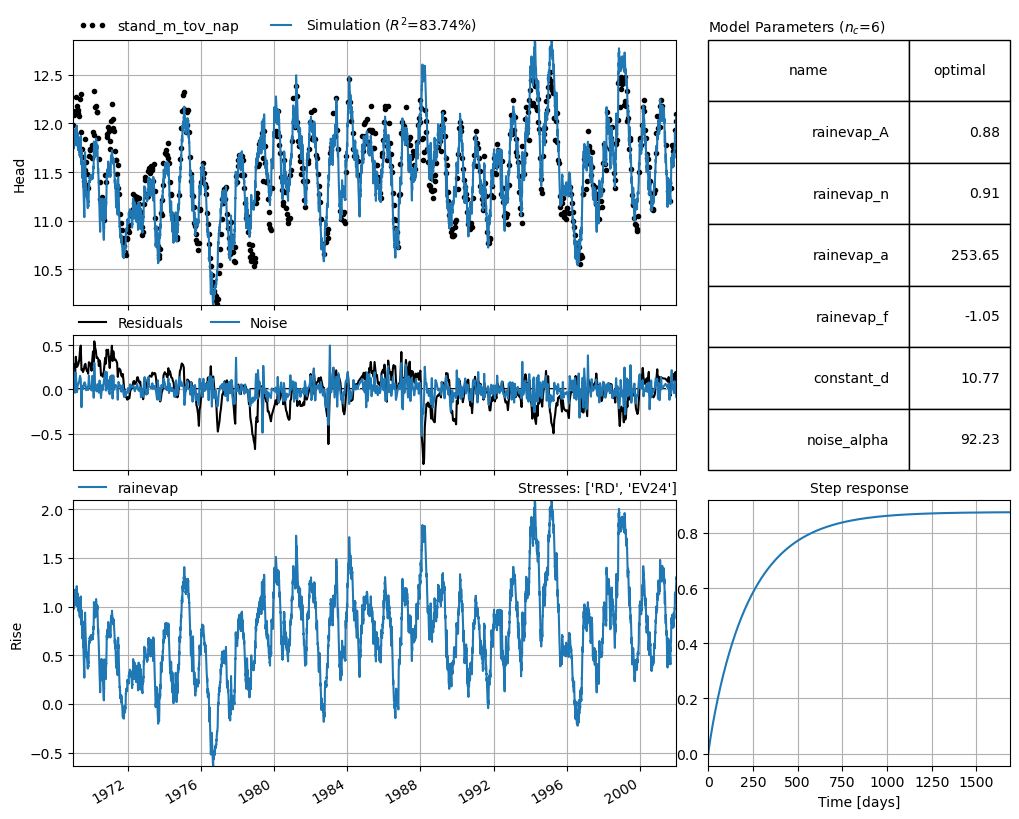

In [6]:
# BUILD MODEL
ml = ps.Model(series, name= gw_levels.name)
ts1 = ps.RechargeModel(
    precipitation["RD"].resample("D").first() * 1000,       # Carefull with the units
    evaporation["EV24"].resample("D").first() * 1000,
    rfunc=ps.Gamma(),
    name="rainevap",
    recharge=ps.rch.Linear(),
    settings=("prec", "evap"),
)
ml.add_stressmodel(ts1)
nm = ps.ArNoiseModel()
ml.add_noisemodel(nm)

# SOLVE MODEL
# In the loop we solve as follows:
# ml.solve(tmin=strtime ,tmax=gw_levels.index[-1], report=False)    
# However, we compare with vd Spek and use the same timeframe in the example:
ml.solve(tmin='1969' ,tmax='2002', report=True) 

ml.plots.results();

## Diagnostic Checks

Before we perform the uncertainty quantification, make sure that the underlaying statistical assumptions are met.

The NSE: 0.837


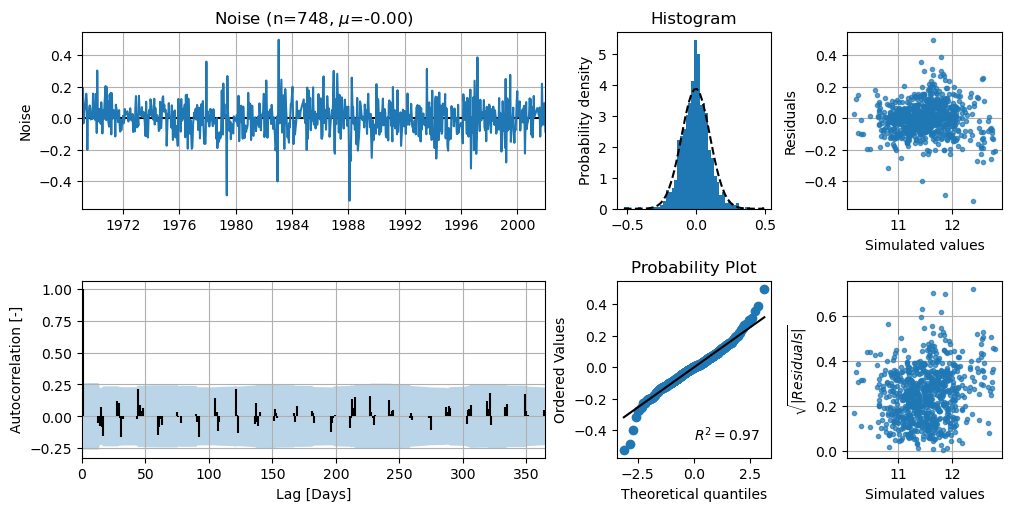

In [7]:
ml.plots.diagnostics();

# Check the NSE:
print(f'The NSE: {ml.stats.nse():.3f}')

# Confidence interval

The solver.ci_simulation function is used to calculate the confidence interval. To compute the confidence interval, parameter sets are drawn from a multivariate normal distribution based on the Jacobian matrix obtained during parameter optimization. The Pastas model object contains this information, and can be accessed when the attribute is added to the model object. Referring to the [Uncertainty Quantification](https://pastas.readthedocs.io/latest/examples/uncertainty.html) example, where the same approach is applied. 

The mean value of the confidence interval (CI) is 0.143 m


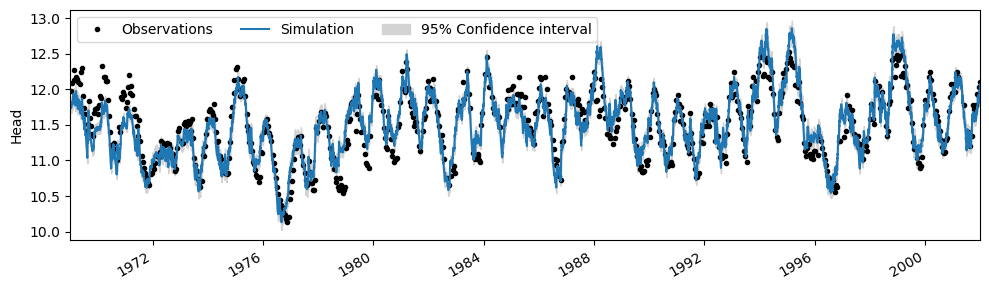

In [8]:
# Solve Ci Pastas
ci = ml.solver.ci_simulation(alpha=0.05, n=1000)     # This make the outcome slightly variable
ax = ml.plot(figsize=(10, 3))
ax.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color="lightgrey")
ax.legend(["Observations", "Simulation", "95% Confidence interval"], ncol=3, loc=2)
ci_pastas = np.mean(ci[0.975]- ci[0.025])
print(f'The mean value of the confidence interval (CI) is {ci_pastas:.3f} m')

# Prediction interval

Simularly to the CI, the prediction interval is can be computed from the solver function. The solver.prediction_interval function is used to calculate the prediction interval. Where the confidence interval estimates the mean of the population, the predcition interval predicts for individual observations and accounts for both sampling and observation variability. A small PI suggests high confidence in predictions.

The mean value of the prediction interval (PI) is 0.768 m


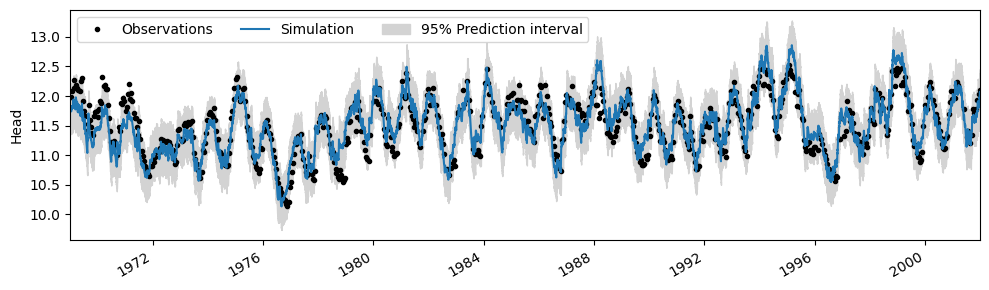

In [9]:
# Solve Pi Pastas
pi = ml.solver.prediction_interval(n=1000)
ax = ml.plot(figsize=(10, 3))
ax.fill_between(pi.index, pi.iloc[:, 0], pi.iloc[:, 1], color="lightgray")
ax.legend(["Observations", "Simulation", "95% Prediction interval"], ncol=3, loc=2)
pi_pastas = np.mean(pi[0.975]- pi[0.025])
print(f'The mean value of the prediction interval (PI) is {pi_pastas:.3f} m')

A short test to check that whether most of the observations fall within the 95% Prediction interval:

In [10]:
print(f'Percentage of observations covered by the prediction interval (PICP): {ps.stats.picp(series[pi.index[0] : pi.index[-1]], pi):.3f}')

Percentage of observations covered by the prediction interval (PICP): 0.952


# Normalize
In order to compare this model with other models, we normalise the prediction and the confidence interval through dividing them by the 95% head range of the observations.

In [11]:
# Calculate head range
flattened = ml.observations().values.flatten()
h025, h50, h975 = pd.Series(flattened).quantile([0.025, 0.5, 0.975]) 
headrange = h975 - h025

npi = pi_pastas / headrange
nci = ci_pastas / headrange

# Calculate the step response function
step_response = ml.get_step_response('rainevap')
t90 = step_response.index[step_response.values >= 0.90 * ml.parameters.loc['rainevap_A', 'optimal']][0]
print(f"Response time (t90): {t90} days")

Response time (t90): 543.0 days


## Parameter comparinson vd Spek vs Pastas

Overall the parameters are simular: Here vd Spek found the following values:

In [12]:
columns = ['Method', 't90 (d)', 'NSE', 'Normalized CI', 'Normalized PI']
vdspek = ['vd Spek', 559, 0.83, 0.080, 0.450]
pastas = ['Pastas', t90, ml.stats.nse(), nci, npi]  # Ensure these variables are defined
compare = pd.DataFrame([vdspek, pastas], columns=columns)
compare_form = (compare.style.format({'t90 (d)': "{:.2f}",'NSE': "{:.3f}",'Normalized CI': "{:.3f}",'Normalized PI': "{:.3f}"}))  # Correct column names in the format
compare_form

,Method,t90 (d),NSE,Normalized CI,Normalized PI
0,vd Spek,559.00,0.830,0.080,0.450
1,Pastas,543.00,0.837,0.083,0.446


It can be seen that the values of the normalized CI and PI are very similar to Van Der Spek & Bakker (2017), giving an indication that the Pastas build in functions are working well. Let's test this on more datasets!

# Compare multiple datasets

Here we loop through the list with 18 groundwater wells and create a simular plot as fig 10 in vd Spek (2017):

In [13]:
results = []

for gw_levels in gw_levels_list:     
    series = gw_levels["stand_m_tov_nap"].dropna()                        
    ref_tindex = series.resample('2W').first().index                      # make sure to have the same sampeling frequency in each dataset  
    tindex = series.index
    sel_index = ps.timeseries_utils.get_sample(tindex=tindex, ref_tindex=ref_tindex)
    series = series.loc[sel_index]


    # First set proper time parameters:
    time = str(gw_levels.index[-1].year - 10)                             # Start validation is 10 years in the past.

    if gw_levels.index[0].year < (gw_levels.index[-1].year - 30):         # If statement which takes the best starting times for calibration and validation period.
        strtime = str(int(time) - 20)
    else:
        strtime = str(gw_levels.index[0].year + 1)                        # Pick the first complete year of the time series.
        time = str(int(strtime) + 20)                                     # In order to stay constitent, make sure there is a calibration period of 20 years


    # Load evap and Prec data from KNMI
    evaporation = hpd.EvaporationObs.from_knmi(
        xy=(gw_levels.x, gw_levels.y),                                    # Get nearest station
        meteo_var="EV24",                                                 # EV24; Use weather station
        start=gw_levels.index[0],
        end=gw_levels.index[-1],
        fill_missing_obs=True,
    )
    
    precipitation = hpd.PrecipitationObs.from_knmi(
        xy=(gw_levels.x, gw_levels.y),                                    # Get nearest station
        meteo_var= 'RD',                                                  # RD; Use the daily precipitaiton from nearest precipitation station
        start=gw_levels.index[0],
        end=gw_levels.index[-1],
        fill_missing_obs=True,
    )
    
    # BUILD MODEL
    ml = ps.Model(series, name= gw_levels.name)
    ts1 = ps.RechargeModel(
        precipitation["RD"].resample("D").first() * 1000,
        evaporation["EV24"].resample("D").first() * 1000,
        rfunc=ps.Gamma(),
        name="rainevap",
        recharge=ps.rch.Linear(),
        settings=("prec", "evap"),
    )
    ml.add_stressmodel(ts1)
    nm = ps.ArNoiseModel()
    ml.add_noisemodel(nm)

    # SOLVE MODEL
    ml.solve(tmin=strtime, tmax=time, report=False) 
    # ml.simulate(tmin=time, tmax=gw_levels.index[-1])
    
    # Solve Ci Pastas
    ci = ml.solver.ci_simulation(alpha=0.05, n=1000)                      
    ci_mean = np.mean(ci[0.975]- ci[0.025])
    
    # Pi
    pi = ml.solver.prediction_interval(n=1000)
    pi_mean = np.mean(pi[0.975]- pi[0.025])

    
    # Check PICP
    # df = pd.concat([ml.observations().rename("obs"), pi.iloc[:, 0].rename("low"), pi.iloc[:, 1].rename("up")], axis=1, join="inner")
    PICP = ps.stats.picp(series[pi.index[0] : pi.index[-1]], pi)
    
    # Calculate the step response function
    step_response = ml.get_step_response('rainevap')
    A_parameter = ml.parameters.loc['rainevap_A', 'optimal']
    T90 = step_response.index[step_response.values >= 0.90 * A_parameter][0]
    
    # Calculate head range
    flattened = ml.observations().values.flatten()
    h025, h50, h975 = pd.Series(flattened).quantile([0.025, 0.5, 0.975]) 
    headrange = h975 - h025
    
    # Normalize
    npi = pi_mean/headrange
    nci = ci_mean/headrange
    
    nse = ml.stats.nse()
    
    results.append({
        "resp_t": T90, 
        'gw_level_name': gw_levels.name,
        "nse": nse, 
        "head range": headrange, 
        "nci": nci,
        "npi": npi, 
        "picp": PICP,
    })
    print('.', end='')                                                              # Indication of how many loops have taken place
    
results_df = pd.DataFrame(results)    
    

..................

### Dataframe

In the loop, a few values are saved in order to check whether the values make sense: 
- Resp_t: The response time of the system.
- The NSE is the Nash-Sutcliff coefficient, which should be around 0.80 or higher. 
- Head range: Is the 95% head range of the observations. Used for the normalization of the CI and PI
- nci & npi, the normalized confidence interval and the normalized prediction interval
- picp: The percentage of the observed groundwater levels that falls within the 95% prediction interval.


In [14]:
results_df

,resp_t,gw_level_name,nse,head range,nci,npi,picp
0,317.0,B09B0124-001,0.854559,0.83475,0.057868,0.424069,0.939791
1,172.0,B09D0360-001,0.766169,1.39200,0.103467,0.586750,0.928753
2,125.0,B11C0329-001,0.744764,0.69175,0.095643,0.555480,0.940092
3,371.0,B12B0001-001,0.849191,1.34050,0.097660,0.408868,0.956818
4,521.0,B12G0075-001,0.892278,1.57800,0.060674,0.330139,0.955083
5,142.0,B22C0090-001,0.828563,1.46000,0.064802,0.440788,0.967366
6,66.0,B27H0042-001,0.743707,0.60575,0.075269,0.516255,0.952153
7,282.0,B32C0572-001,0.801374,0.88300,0.090973,0.464658,0.953684
8,582.0,B32E0031-001,0.835802,1.63775,0.108802,0.456988,0.964444
9,528.0,B33B0505-001,0.600537,1.32925,0.204078,0.617138,0.950549


In [20]:
results_df.to_csv('pastas.csv', index=False)

In [18]:
# Read the data into a DataFrame
df_CI = pd.read_csv('data/nCI_spek.txt', comment='#', header=None, names=['X', 'Y'])
df_PI = pd.read_csv('data/nPI_spek.txt', comment='#', header=None, names=['X', 'Y'])

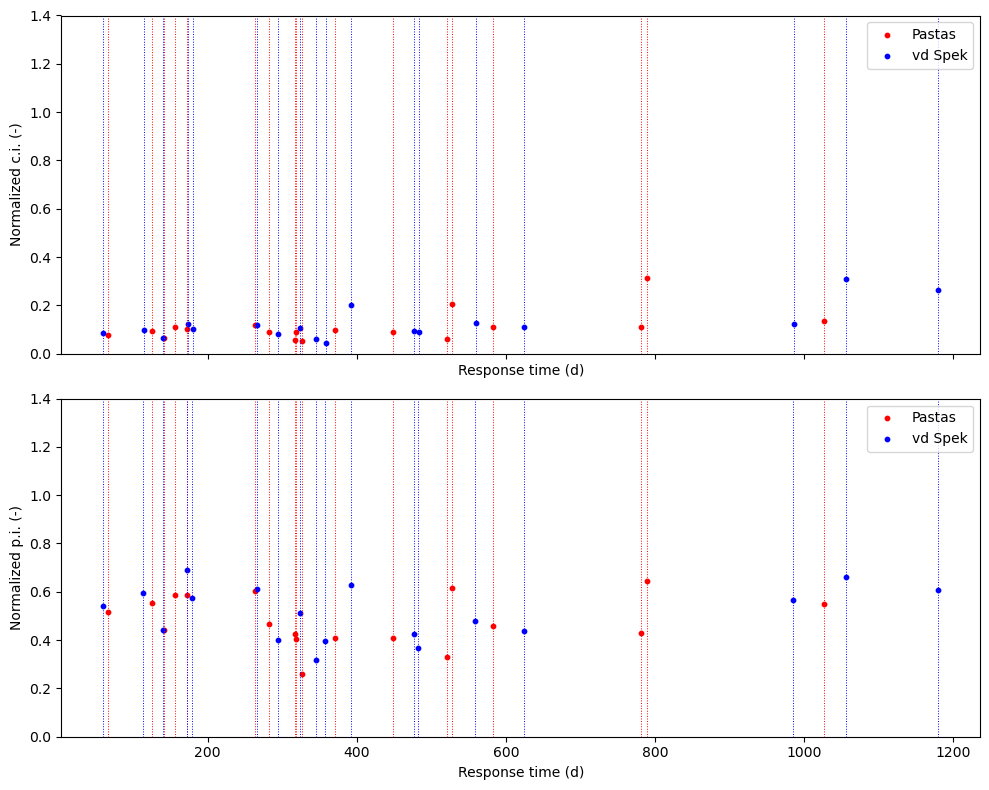

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Confidence Interval (CI) Plot
axes[0].scatter(results_df['resp_t'], results_df['nci'], color='red', s=10, label="Pastas")
axes[0].vlines(results_df['resp_t'], ymin=0, ymax=1.4, colors='red', linestyles='dotted', linewidth=0.7)

axes[0].scatter(df_CI['X'], df_CI['Y'], color='blue', s=10, label="vd Spek") 
axes[0].vlines(df_CI['X'], ymin=0, ymax=1.4, colors='blue', linestyles='dotted', linewidth=0.7)

axes[0].set_ylim(0, 1.4)
axes[0].set_xlabel("Response time (d)")
axes[0].set_ylabel("Normalized c.i. (-)")
axes[0].legend()

# Prediction Interval (PI) Plot
axes[1].scatter(results_df['resp_t'], results_df['npi'], color='red', s=10, label="Pastas")
axes[1].vlines(results_df['resp_t'], ymin=0, ymax=1.4, colors='red', linestyles='dotted', linewidth=0.7)

axes[1].scatter(df_PI['X'], df_PI['Y'], color='blue', s=10, label="vd Spek") 
axes[1].vlines(df_PI['X'], ymin=0, ymax=1.4, colors='blue', linestyles='dotted', linewidth=0.7)

axes[1].set_ylim(0, 1.4)
axes[1].set_xlabel("Response time (d)")
axes[1].set_ylabel("Normalized p.i. (-)")
axes[1].legend()

# Show the plots
plt.tight_layout()
plt.show()

Comparing both plots, we can see that the response time is different for both methods, but the values of the normalized prediction and confindence interval are similar height. Getting relatively similar results with the quick use of Pastas in comparinson to an extensive MCMC analysis.

### Sources used:

- Van der Spek, J. E., and M. Bakker (2017), The influence of the length of the calibration period and observation frequency on predictive uncertainty in time series modeling of groundwater dynamics, Water Resour. Res., 53, 2294–2311, doi:10.1002/2016WR019704, from:[https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016WR019704](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016WR019704). 

Data:
- KNMI, Koninklijk Nederlands Meteorologisch Instituut, from [https://dataplatform.knmi.nl](https://dataplatform.knmi.nl)

- DINOloket, Data en Informatie van de Nederlandse Ondergrond, from [https://www.dinoloket.nl/ondergrondgegevens](https://www.dinoloket.nl/ondergrondgegevens)